In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import copy
from football_sim.all import Calibrator, Season,Settings
%matplotlib inline

In [2]:
base_dir = './'

settings = Settings(os.path.join(base_dir, 'config.yaml'))
calib = Calibrator(settings)
calib.download_all_data() 
calib.process_data()
year = 2019
league = 'BPL'
calib.calibrate_teams(league,year)

In [3]:
season = Season(league, year,calib, use_home_advantage=False)
print('home advantage', season.home_advantage)

season.process_current_results()
season.simulate_season(n_scenarios=100000)
season.process_simulation()

home advantage 1


In [4]:
i=season.match_id['bpl_astonvilla_manchesterunited_2020-07-09']

hg=season.simulated_home_goals[i,:]
ag=season.simulated_away_goals[i,:]
ind = ag>hg
#ind = None
season.season_report(ind=ind)

,Played,Points (current),Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Liverpool,34,92,99.9,96,104,1,1,100.0,100.00,5.83,0.27,0.00
Manchester City,34,69,79.5,76,81,2,2,0.0,100.00,7.16,0.19,0.00
Chelsea,34,60,67.0,63,72,5,3,0.0,74.79,5.33,0.31,0.00
Manchester United,33,55,66.2,62,70,5,3,0.0,65.32,5.16,0.22,0.00
Leicester City,34,59,65.6,62,69,5,3,0.0,59.60,4.33,0.28,0.00
Wolverhampton,34,52,58.1,54,62,9,6,0.0,0.24,3.12,0.22,0.00
Arsenal,34,50,56.4,52,60,10,6,0.0,0.00,4.26,0.29,0.00
Tottenham Hotspur,33,48,55.5,51,60,11,6,0.0,0.03,4.01,0.36,0.00
Sheffield United,34,51,55.1,52,60,11,6,0.0,0.02,3.04,0.33,0.00
Burnley,34,49,53.5,50,58,12,7,0.0,0.00,2.97,0.35,0.00


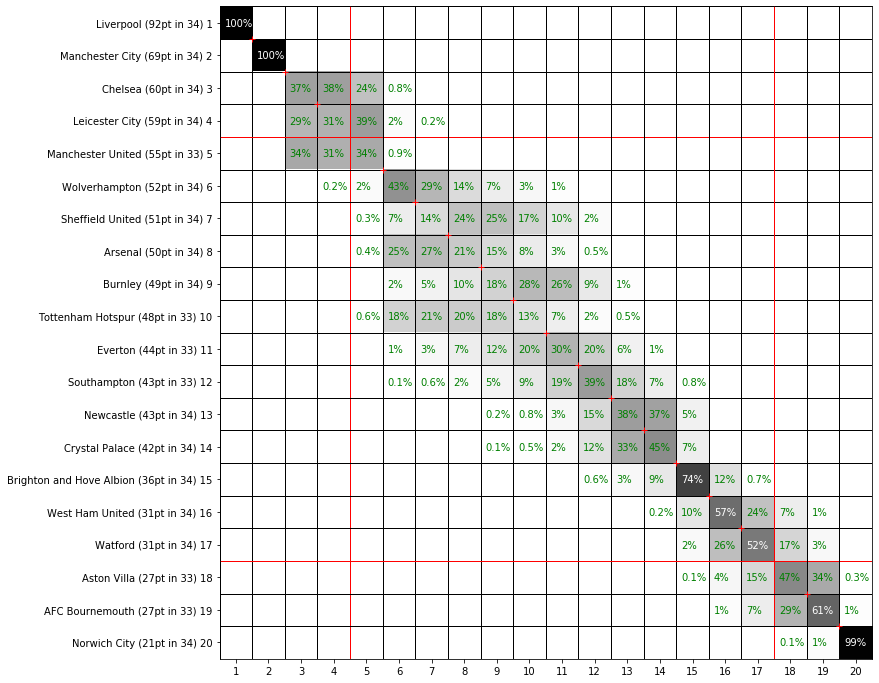

In [5]:
season.probability_grid(ind=ind);

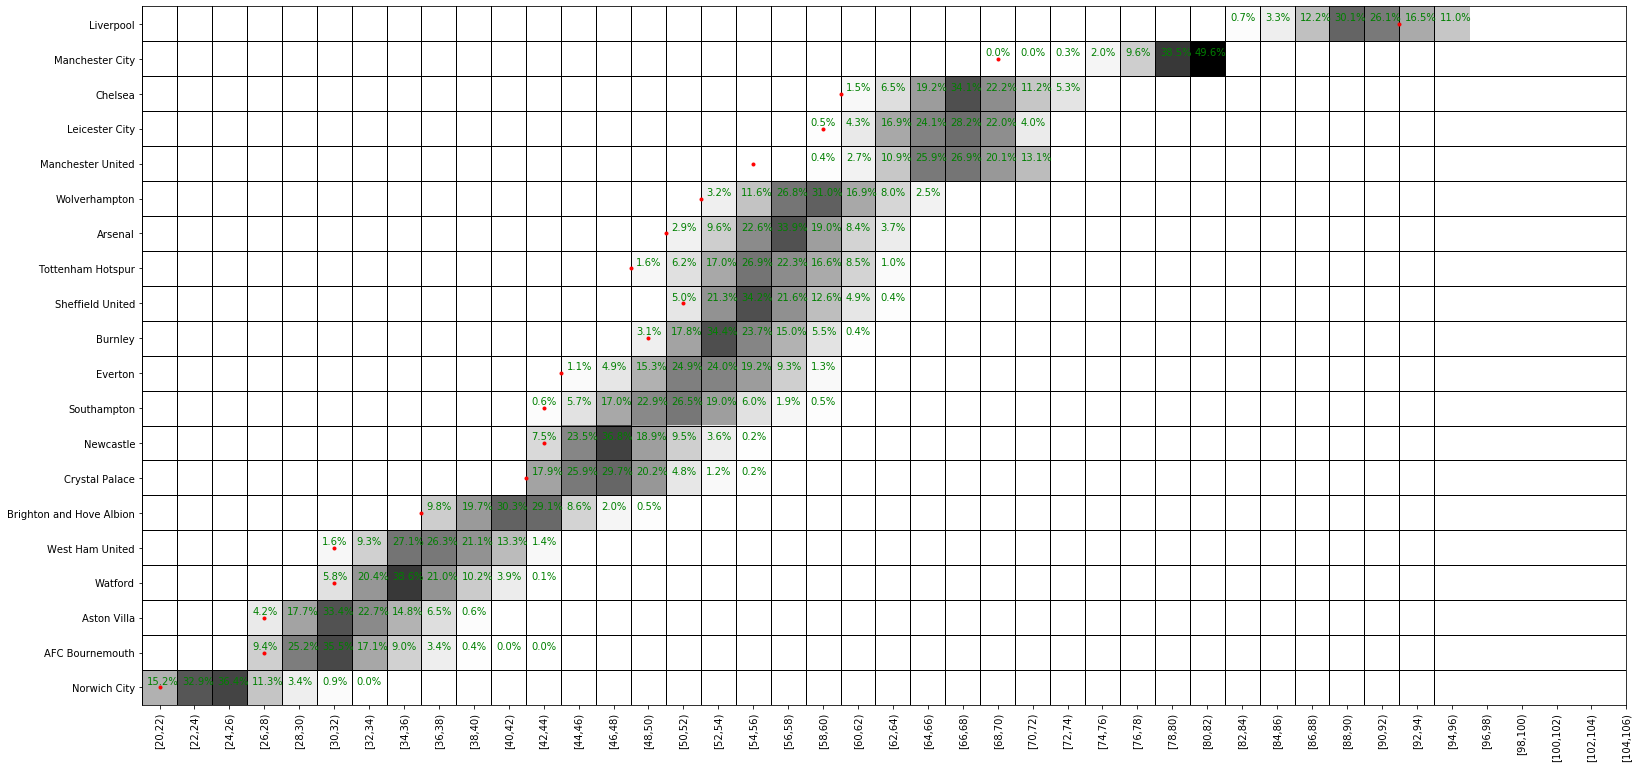

In [6]:
season.points_probability_grid(ind=ind);

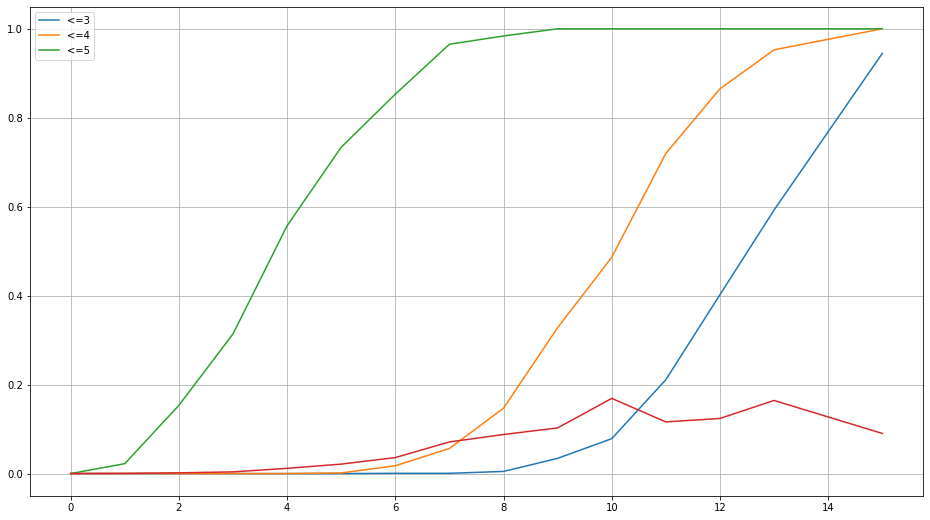

In [7]:

def plot_place_per_points(team_name,lgh):
    p0=lgh.current_points[team_name]

    i=lgh.team_id[team_name]

    #p0=league.current_points['Wolverhampton']
    #i = league.team_id['Wolverhampton']

    P=(lgh.points_per_team[i,:]-p0).astype(int)
    pp=np.unique(P)

    prob4=[]
    prob3=[]
    prob5=[]
    probp=[]
    for p in pp:
        ind =( P==p)
        probp.append(ind.sum()/ind.size)
        prob4.append(np.sum(lgh.place_per_team[i,ind]<=4)/ind.sum())
        prob3.append(np.sum(lgh.place_per_team[i,ind]<=3)/ind.sum())
        prob5.append(np.sum(lgh.place_per_team[i,ind]<=5)/ind.sum())

    C = len([x for x in lgh.matches_to_sim if team_name in [x.home_team.name,x.away_team.name]])
    C=1
    plt.figure(figsize=(16,9))
    plt.plot(pp/C,prob3,label='<=3')
    plt.plot(pp/C,prob4,label='<=4')
    plt.plot(pp/C,prob5,label='<=5')
    plt.plot(pp/C,probp)
    plt.grid(True)
    plt.legend()
plot_place_per_points(season.teams['Manchester United'].name,season)
#plot_place_per_points(league.teams['Wolverhampton'].name,league)

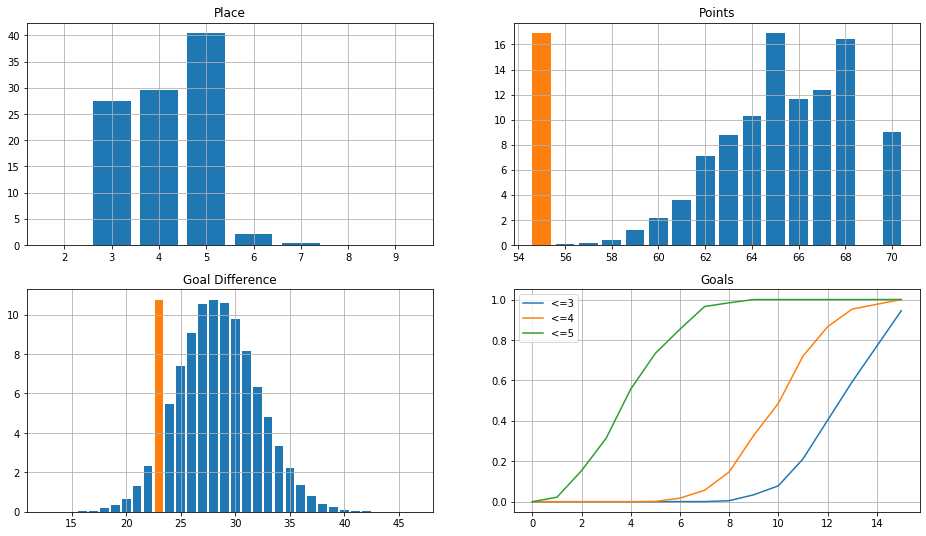

In [8]:
my_team = season.teams['Manchester United']

names = []
importance = []
for m in season.matches_to_sim:
    p=season.what_if(m,ref_team=my_team,place=4,or_better=True,show_plot=False)[0]
    names.append(m.id)
    importance.append(np.sum((p[1:]-p[0])**2))

names=np.array(names)
importance=np.array(importance)

isort = np.argsort(-importance)
names=names[isort]
importance=importance[isort]
season.team_report(my_team)

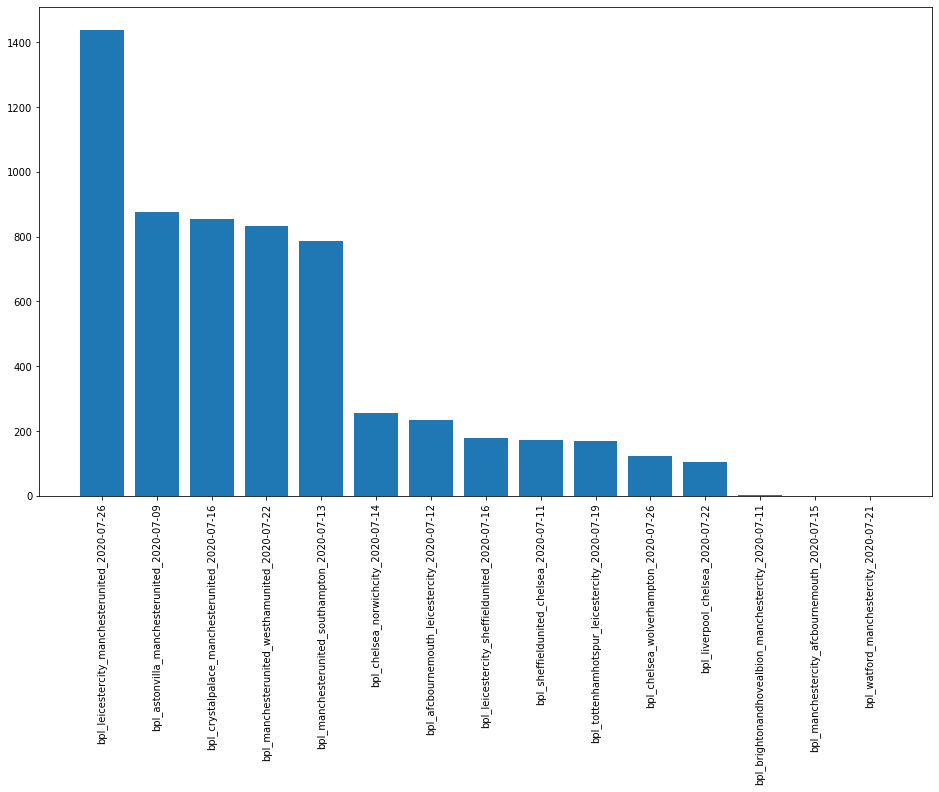

In [9]:
n_plot=15

plt.figure(figsize=(16,9))
plt.bar(np.arange(n_plot),importance[:n_plot])
plt.xticks(np.arange(n_plot),names[:n_plot],rotation=90);

(array([57.102     , 32.62508568, 65.32097852, 42.58790726]),
 <Figure size 1152x648 with 1 Axes>)

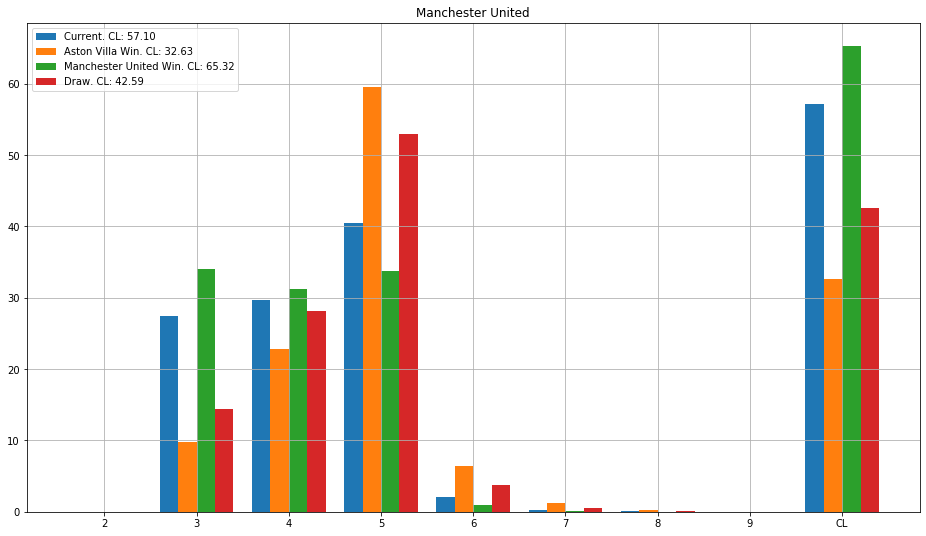

In [10]:
match = season.matches_to_sim[season.match_id['bpl_astonvilla_manchesterunited_2020-07-09']]
my_team=season.teams['Manchester United']
season.what_if(match,ref_team=my_team,place=4,or_better=True)

In [11]:
season.matches_remaining()

,Date,Home,Away,Home Wins,Draw,Away Wins,av HG,av AG
0,2020-07-09,Aston Villa,Manchester United,11.7,19.4,69.0,0.7,2.1
1,2020-07-09,Everton,Southampton,39.7,27.4,32.9,1.3,1.2
2,2020-07-09,AFC Bournemouth,Tottenham Hotspur,23.0,22.0,55.1,1.2,2.0
3,2020-07-11,Brighton and Hove Albion,Manchester City,7.9,14.6,77.5,0.7,2.5
4,2020-07-11,Sheffield United,Chelsea,19.6,23.4,57.0,0.9,1.7
5,2020-07-11,Liverpool,Burnley,66.6,19.7,13.7,2.1,0.8
6,2020-07-11,Norwich City,West Ham United,22.5,24.3,53.2,1.0,1.6
7,2020-07-11,Watford,Newcastle,41.7,26.5,31.8,1.4,1.2
11,2020-07-12,Wolverhampton,Everton,36.9,34.0,29.1,0.9,0.8
10,2020-07-12,Aston Villa,Crystal Palace,36.4,26.9,36.7,1.2,1.3


In [12]:
[f for f in season.matches_to_sim if 'Leicester City' in [f.home_team.name,f.away_team.name]]

[             metric  AFC Bournemouth  Leicester City
 0             goals              NaN             NaN
 1                xg              NaN             NaN
 2              nsxg              NaN             NaN
 3                ag              NaN             NaN
 4  forecasted goals          0.91569         2.12541
 5   win probability         15.09400        65.20700
 6  draw probability         19.69900        19.69900,
              metric  Leicester City  Sheffield United
 0             goals             NaN               NaN
 1                xg             NaN               NaN
 2              nsxg             NaN               NaN
 3                ag             NaN               NaN
 4  forecasted goals         1.42497           0.84078
 5   win probability        50.74800          22.17300
 6  draw probability        27.07900          27.07900,
              metric  Tottenham Hotspur  Leicester City
 0             goals                NaN             NaN
 1            

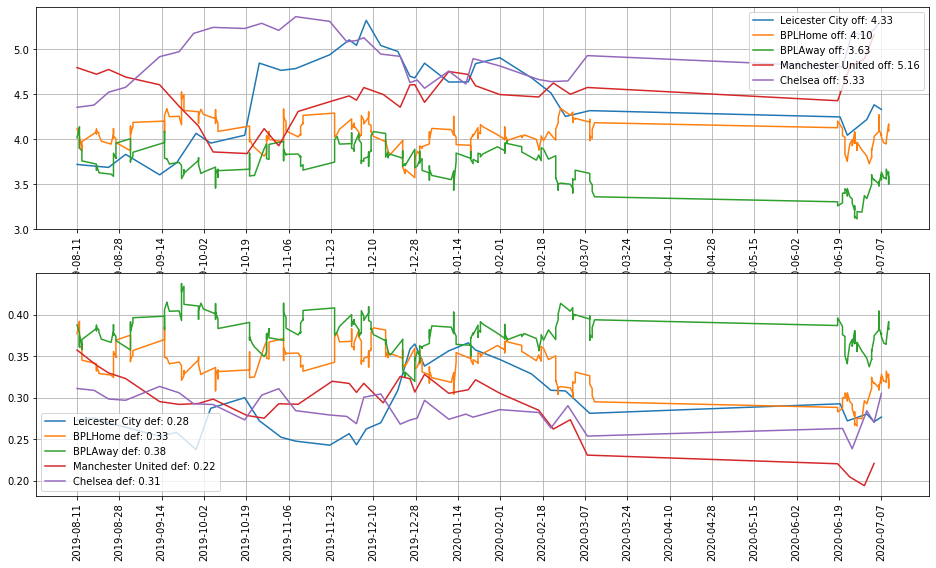

In [13]:
ax=None
for team in calib.teams.values():
    if team.name in ['Manchester United','Leicester City','Chelsea','BPLHome','BPLAway']:
    #if team.name in ['BPLHome','BPLAway']:
        ax=team.plt(ax=ax)
        #ax[0].axvline(x=37)
        #ax[1].axvline(x=37)


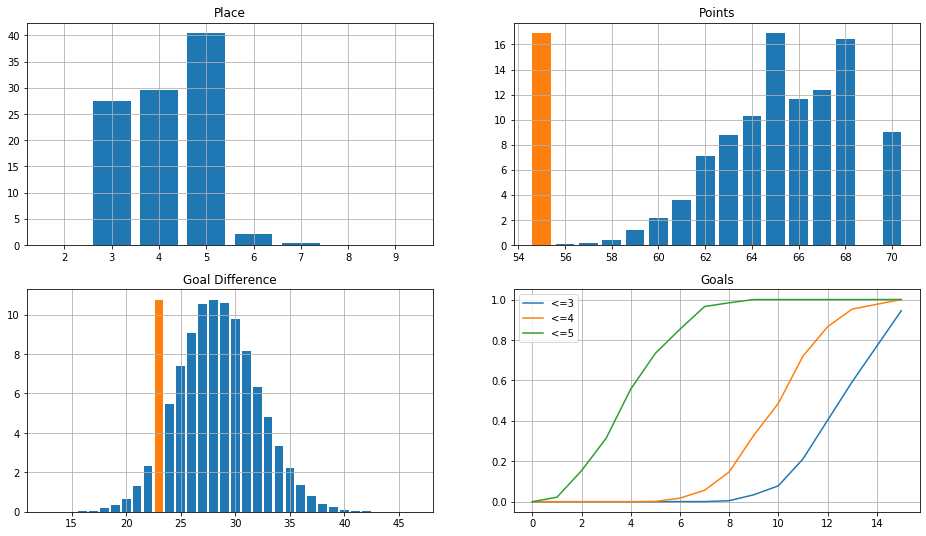

In [14]:
season.team_report(my_team)

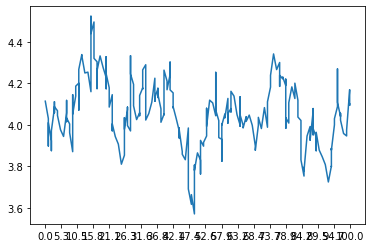

In [15]:
team = calib.teams['BPL__BPLHome']
#team = calib.teams['BPL_ManchesterUnited']
uD,iD=np.unique(team.t,return_inverse=True)
plt.plot(iD,team.offense_hist)

xticks=np.linspace(0,iD.max(),20)
plt.xticks(xticks);


In [16]:
xticks = np.linspace(0, len(my_team.t), 20)

[my_team.t[0]+(my_team.t[-1]-my_team.t[0])*x for x in xticks/len(my_team.t)]

[Timestamp('2019-08-11 00:00:00'),
 Timestamp('2019-08-28 06:18:56.842105263'),
 Timestamp('2019-09-14 12:37:53.684210526'),
 Timestamp('2019-10-01 18:56:50.526315790'),
 Timestamp('2019-10-19 01:15:47.368421053'),
 Timestamp('2019-11-05 07:34:44.210526315'),
 Timestamp('2019-11-22 13:53:41.052631580'),
 Timestamp('2019-12-09 20:12:37.894736844'),
 Timestamp('2019-12-27 02:31:34.736842106'),
 Timestamp('2020-01-13 08:50:31.578947370'),
 Timestamp('2020-01-30 15:09:28.421052630'),
 Timestamp('2020-02-16 21:28:25.263157896'),
 Timestamp('2020-03-05 03:47:22.105263160'),
 Timestamp('2020-03-22 10:06:18.947368420'),
 Timestamp('2020-04-08 16:25:15.789473688'),
 Timestamp('2020-04-25 22:44:12.631578948'),
 Timestamp('2020-05-13 05:03:09.473684212'),
 Timestamp('2020-05-30 11:22:06.315789472'),
 Timestamp('2020-06-16 17:41:03.157894740'),
 Timestamp('2020-07-04 00:00:00')]

In [17]:
correct = []
p=[]
for f in calib.get_fixtures_for_league('BPL',2019,completed=True):
    correct.append(f.forecast_result==f.result)
    p.append(f.forecast_probability)

In [18]:
pd.to_datetime('today').strftime('%Y-%m-%d')

'2020-07-09'